In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

projRootPath =  os.path.abspath(os.path.join('.' ,"../.."))
print("Project root path is: ", projRootPath)
sys.path.append(projRootPath)

from src.utils.path_manipulation import contains_filetype
from src.utils.viz_functions import make_mel_spectrogram
from src.utils.sound_functions import mix_samples, read_mp3, write_mp3, pad_length_to_max

# modules for visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# modules for data processing
import numpy as np
from scipy import signal
from scipy.io import wavfile
from statistics import median
import wave
import struct
import csv
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error 

# modules for data mining
from sklearn.decomposition import pca, FastICA

# and IPython.display for audio output
from tqdm.notebook import tqdm 
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

from pydub import AudioSegment

Project root path is:  D:\Programming\AudioMining


In [3]:
fs = 1000
f1 = 1
f2 = 2

x = np.arange(fs)

wave1 = np.sin(2*np.pi*f1 * (x/fs))
wave2 = np.sin(2*np.pi*f2 * (x/fs))

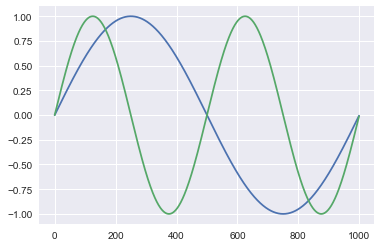

In [4]:
plt.plot(x, wave1, x, wave2)

In [5]:
def generate_mixtures(s1, s2, mixing_matrix):
    S = np.c_[s1, s2]
    S = MinMaxScaler([-1, 1]).fit_transform(S)
    A = np.array(mixing_matrix)
    X = np.dot(S, A.T)
    return S, X

def pair_randomizer(n):
    pairs = []
    for i in range(n):
        pair = np.random.random(2)*3
        pairs.append(pair)
    return pairs

def sample_evaluation(v1, v2, s1, s2, only_min):
    """
    s1, s2: known samples
    v1, v2: samples to be identified
    only_min : if True return only the smallest value
    """
    scaler = MinMaxScaler([-1, 1])
    v1 = scaler.fit_transform(v1.reshape(-1, 1))
    scaler = MinMaxScaler([-1, 1])
    v2 = scaler.fit_transform(v2.reshape(-1, 1))
    
    mse_v1_min_s1 = min(mean_squared_error(s1, v1), mean_squared_error(s1, -1*v1))
    mse_v1_min_s2 = min(mean_squared_error(s2, v1), mean_squared_error(s2, -1*v1))
    
    mse_v2_min_s1 = min(mean_squared_error(s1, v2), mean_squared_error(s1, -1*v2))
    mse_v2_min_s2 = min(mean_squared_error(s2, v2), mean_squared_error(s2, -1*v2))
    
    if only_min:
        val = min(min(mse_v1_min_s1, mse_v1_min_s2), min(mse_v2_min_s1, mse_v2_min_s2))
    else:
        val = min(mse_v1_min_s1, mse_v1_min_s2) + min(mse_v2_min_s1, mse_v2_min_s2)
    return val

In [6]:
# Do ICA
sub_mtx = pair_randomizer(10)

S_orig, mixed_signals = generate_mixtures(wave1, wave2, sub_mtx)
new_mixtures = np.asarray(mixed_signals)

ica_st = FastICA(n_components=2)
S_recov = ica_st.fit_transform(new_mixtures) # Reconstruct signals
A_recov = ica_st.mixing_  # Get estimated mixing matrix

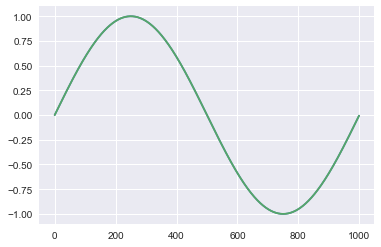

In [7]:
plt.plot(x, wave1, x, S_orig[:, 0])

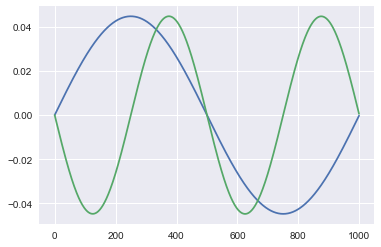

In [9]:
# plot recovered signals
plt.plot(x, S_recov[:, 0], x, S_recov[:, 1])

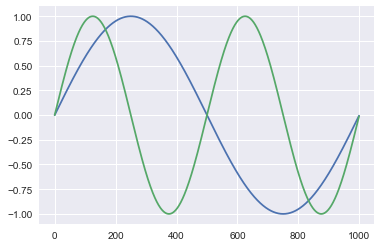

In [10]:
# plot original signals
plt.plot(x, S_orig[:, 0], x, S_orig[:, 1])

In [11]:
sample_evaluation(S_recov[:, 0], S_recov[:, 1], S_orig[:, 0], S_orig[:, 1], False)

4.002896792023973e-07

In [21]:
# rescale recovered signals
recov_wave1 = MinMaxScaler([-1, 1]).fit_transform(S_recov[:, 0].reshape(-1, 1))
recov_wave2 = MinMaxScaler([-1, 1]).fit_transform(S_recov[:, 1].reshape(-1, 1))

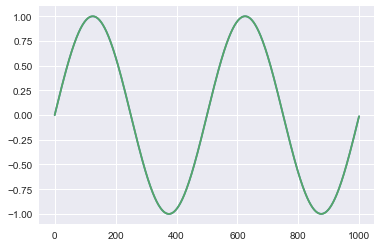

In [25]:
plt.plot(x, -1*recov_wave2, x, S_orig[:, 1])

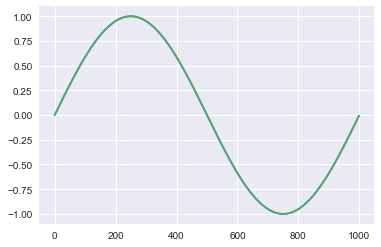

In [27]:
plt.plot(x, recov_wave1, x, S_orig[:, 0])

In [84]:
# validate decomposition with pinv

S_recov_validate = np.dot(new_mixtures, np.linalg.pinv(A_recov.T))
recov_validation_wave1 = MinMaxScaler([-1, 1]).fit_transform(S_recov_validate[:, 0].reshape(-1, 1))
recov_validation_wave2 = MinMaxScaler([-1, 1]).fit_transform(S_recov_validate[:, 1].reshape(-1, 1))

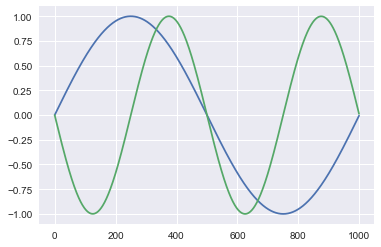

In [85]:
plt.plot(x, recov_validation_wave1, x, recov_validation_wave2)

### Try to decompose a mixed signal from the training set

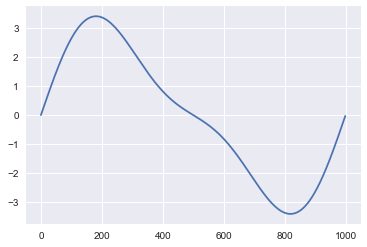

In [45]:
# plot mixture 
plt.plot(x, mixed_signals[:, 4])

In [66]:
 # plot mixture 
mixts_single = mixed_signals[:, 4]
mixts_repeated = np.tile(np.array(mixts_single), (A_recov.shape[0], 1))
mixts_repeated = np.asarray(mixts_repeated.T)

S_recov_single_obs = np.dot(mixts_repeated, np.linalg.pinv(A_recov.T))
recov_single_wave1 = MinMaxScaler([-1, 1]).fit_transform(S_recov_single_obs[:, 0].reshape(-1, 1))
recov_single_wave2 = MinMaxScaler([-1, 1]).fit_transform(S_recov_single_obs[:, 1].reshape(-1, 1))

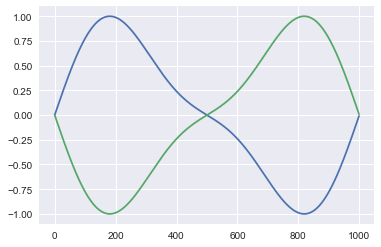

In [70]:
plt.plot(x, recov_single_wave1, x, recov_single_wave2)

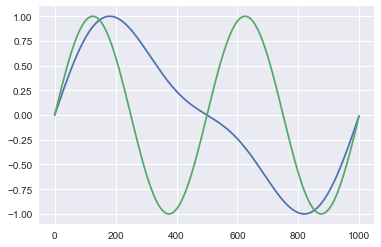

In [71]:
plt.plot(x, recov_single_wave1, x, S_orig[:, 1])

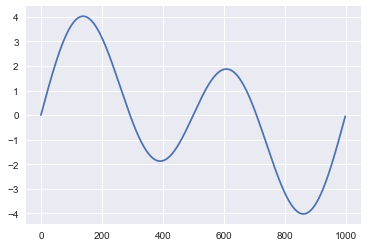

In [75]:
# plot mixture 
plt.plot(x, mixed_signals[:, 2])

In [76]:
 # plot mixture 
mixts_single = mixed_signals[:, 2]
mixts_repeated = np.tile(np.array(mixts_single), (A_recov.shape[0], 1))
mixts_repeated = np.asarray(mixts_repeated.T)

S_recov_single_obs = np.dot(mixts_repeated, np.linalg.pinv(A_recov.T))
recov_single_wave1 = MinMaxScaler([-1, 1]).fit_transform(S_recov_single_obs[:, 0].reshape(-1, 1))
recov_single_wave2 = MinMaxScaler([-1, 1]).fit_transform(S_recov_single_obs[:, 1].reshape(-1, 1))

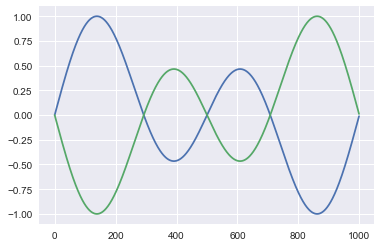

In [78]:
plt.plot(x, recov_single_wave1, x, recov_single_wave2)

In [81]:
mixts_repeated.shape

(1000, 10)

### Batch test

In [90]:
s1_st = wave1 
s2_st = wave2 

# scale the initial samples
scaler = MinMaxScaler([-1, 1])
s1_st = scaler.fit_transform(s1_st.reshape(-1, 1))
scaler = MinMaxScaler([-1, 1])
s2_st = scaler.fit_transform(s2_st.reshape(-1, 1))

batch_size = 10

mse_list = []
for i in tqdm(range(2, 15)):
    
    mse_batch = []
    for j in range(batch_size):
    
        sub_mtx = pair_randomizer(i)

        S_v_orig_st, mixts_v_st = generate_mixtures(s1_st, s2_st, sub_mtx)
        new_mixtures_st = np.asarray(mixts_v_st)

        ica_st = FastICA(n_components=2)
        S_recov_v_st = ica_st.fit_transform(new_mixtures_st) # Reconstruct signals
        A_recov_v_other_st = ica_st.mixing_  # Get estimated mixing matrix
        
        # evaluate decomposition
        mse_batch.append(sample_evaluation(S_recov_v_st[:, 0], S_recov_v_st[:, 1], s1_st, s2_st, False)) 
        
    
    mse_list.append(median(mse_batch))


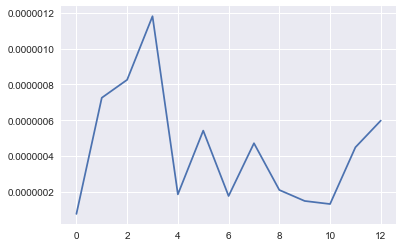

In [91]:
plt.plot(mse_list)

In [92]:
sub_mtx = pair_randomizer(2)

S_orig, mixed_signals = generate_mixtures(wave1, wave2, sub_mtx)
new_mixtures = np.asarray(mixed_signals)

ica_st = FastICA(n_components=2)
S_recov = ica_st.fit_transform(new_mixtures) # Reconstruct signals
A_recov = ica_st.mixing_  # Get estimated mixing matrix

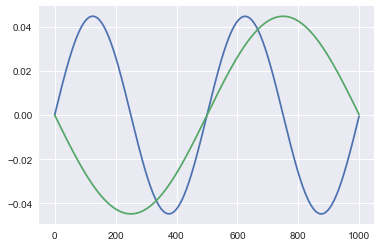

In [93]:
# plot recovered signals
plt.plot(x, S_recov[:, 0], x, S_recov[:, 1])